In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
from loguru import logger

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('/home/mowp/workspace/mowp_scripts/tools')

import os
os.environ['R_HOME'] = '/home/mowp/mambaforge/envs/sc/lib/R'

%load_ext autoreload
%autoreload 1
%aimport sctk

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/umap/distances.py:1086: 

In [3]:
import random
from typing import List

def create_pseudo_bulk(
        cell_subset: sc.AnnData, 
        sample_key: str, 
        condition_key: str,
        n_cells: int = 50,
        n_pseudo_replicates: int = 1,
        counts_key: str = 'counts'
        ) -> List[sc.AnnData]:
    """
    Create pseudo-bulk samples from a subset of cells.

    Parameters
    ----------
    cell_subset
        An AnnData object containing a subset of cells.
    sample_key
        The key in `cell_subset.obs` containing the sample name.
    condition_key
        The key in `cell_subset.obs` containing the condition name.
    n_cells
        The number of cells to sample per donor.
    n_pseudo_replicates
        The number of pseudo-replicates to create for each donor.
    counts_key
        The key in `cell_subset.layers` containing the counts matrix.

    Returns
    -------
    pb
        An AnnData objects containing a pseudo-bulk sample.

    Examples
    --------
    >>> cell_subset = adata[adata.obs['cell_type'] == 'B cells']
    >>> pb_samples = create_pseudo_bulk(cell_subset, 'sample', 'condition')
    """

    assert counts_key in cell_subset.layers.keys(), f"counts_key {counts_key} not found in cell_subset.layers.keys()"

    pbs = []
    for sample in cell_subset.obs[sample_key].unique():
        samp_cell_subset = cell_subset[cell_subset.obs[sample_key] == sample]
        
        samp_cell_subset.X = samp_cell_subset.layers[counts_key] #make sure to use raw data
        
        indices = list(samp_cell_subset.obs_names)
        if len(indices) < n_cells * n_pseudo_replicates:
            logger.info(f"Skipping group {sample} with {len(indices)} cells, which is less than {n_cells * n_pseudo_replicates}")
            continue
        
        random.seed(1)
        random.shuffle(indices)
        indices = np.array_split(np.array(indices), n_pseudo_replicates) #change number here for number of replicates deisred
        
        for i, pseudo_rep in enumerate(indices):
            rep_adata = sc.AnnData(
                X = samp_cell_subset[indices[i]].X.sum(axis = 0),
                var = samp_cell_subset[indices[i]].var[[]])

            rep_adata.obs_names = [sample + '_' + str(i)]
            rep_adata.obs['condition'] = samp_cell_subset.obs[condition_key].iloc[0]
            rep_adata.obs['replicate'] = i
            rep_adata.obs['psbulk_n_cells'] = len(indices[i])
            rep_adata.obs['psbulk_counts'] = rep_adata.X.sum()

            pbs.append(rep_adata)
        
    pb = sc.concat(pbs)

    return pb

In [4]:
infile = '/data/user/mowp/workspace/single_cell_analysis/single-cell-best-practics/dataset/kang.h5ad'

adata = sc.read(
    filename=infile,
)

In [5]:
adata.obs

,nCount_RNA,nFeature_RNA,tsne1,tsne2,label,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
index,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGCCTGAA-2,1033.0,468,18.268321,1.058202,stim,6,CD4 T cells,patient_1244,1128.0,468,2,2
TTTGCATGCCTGTC-2,2116.0,819,-11.563067,2.574095,stim,4,B cells,patient_1256,1669.0,799,3,3
TTTGCATGCTAAGC-2,1522.0,523,25.142392,6.603815,stim,6,CD4 T cells,patient_107,1422.0,523,0,0


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


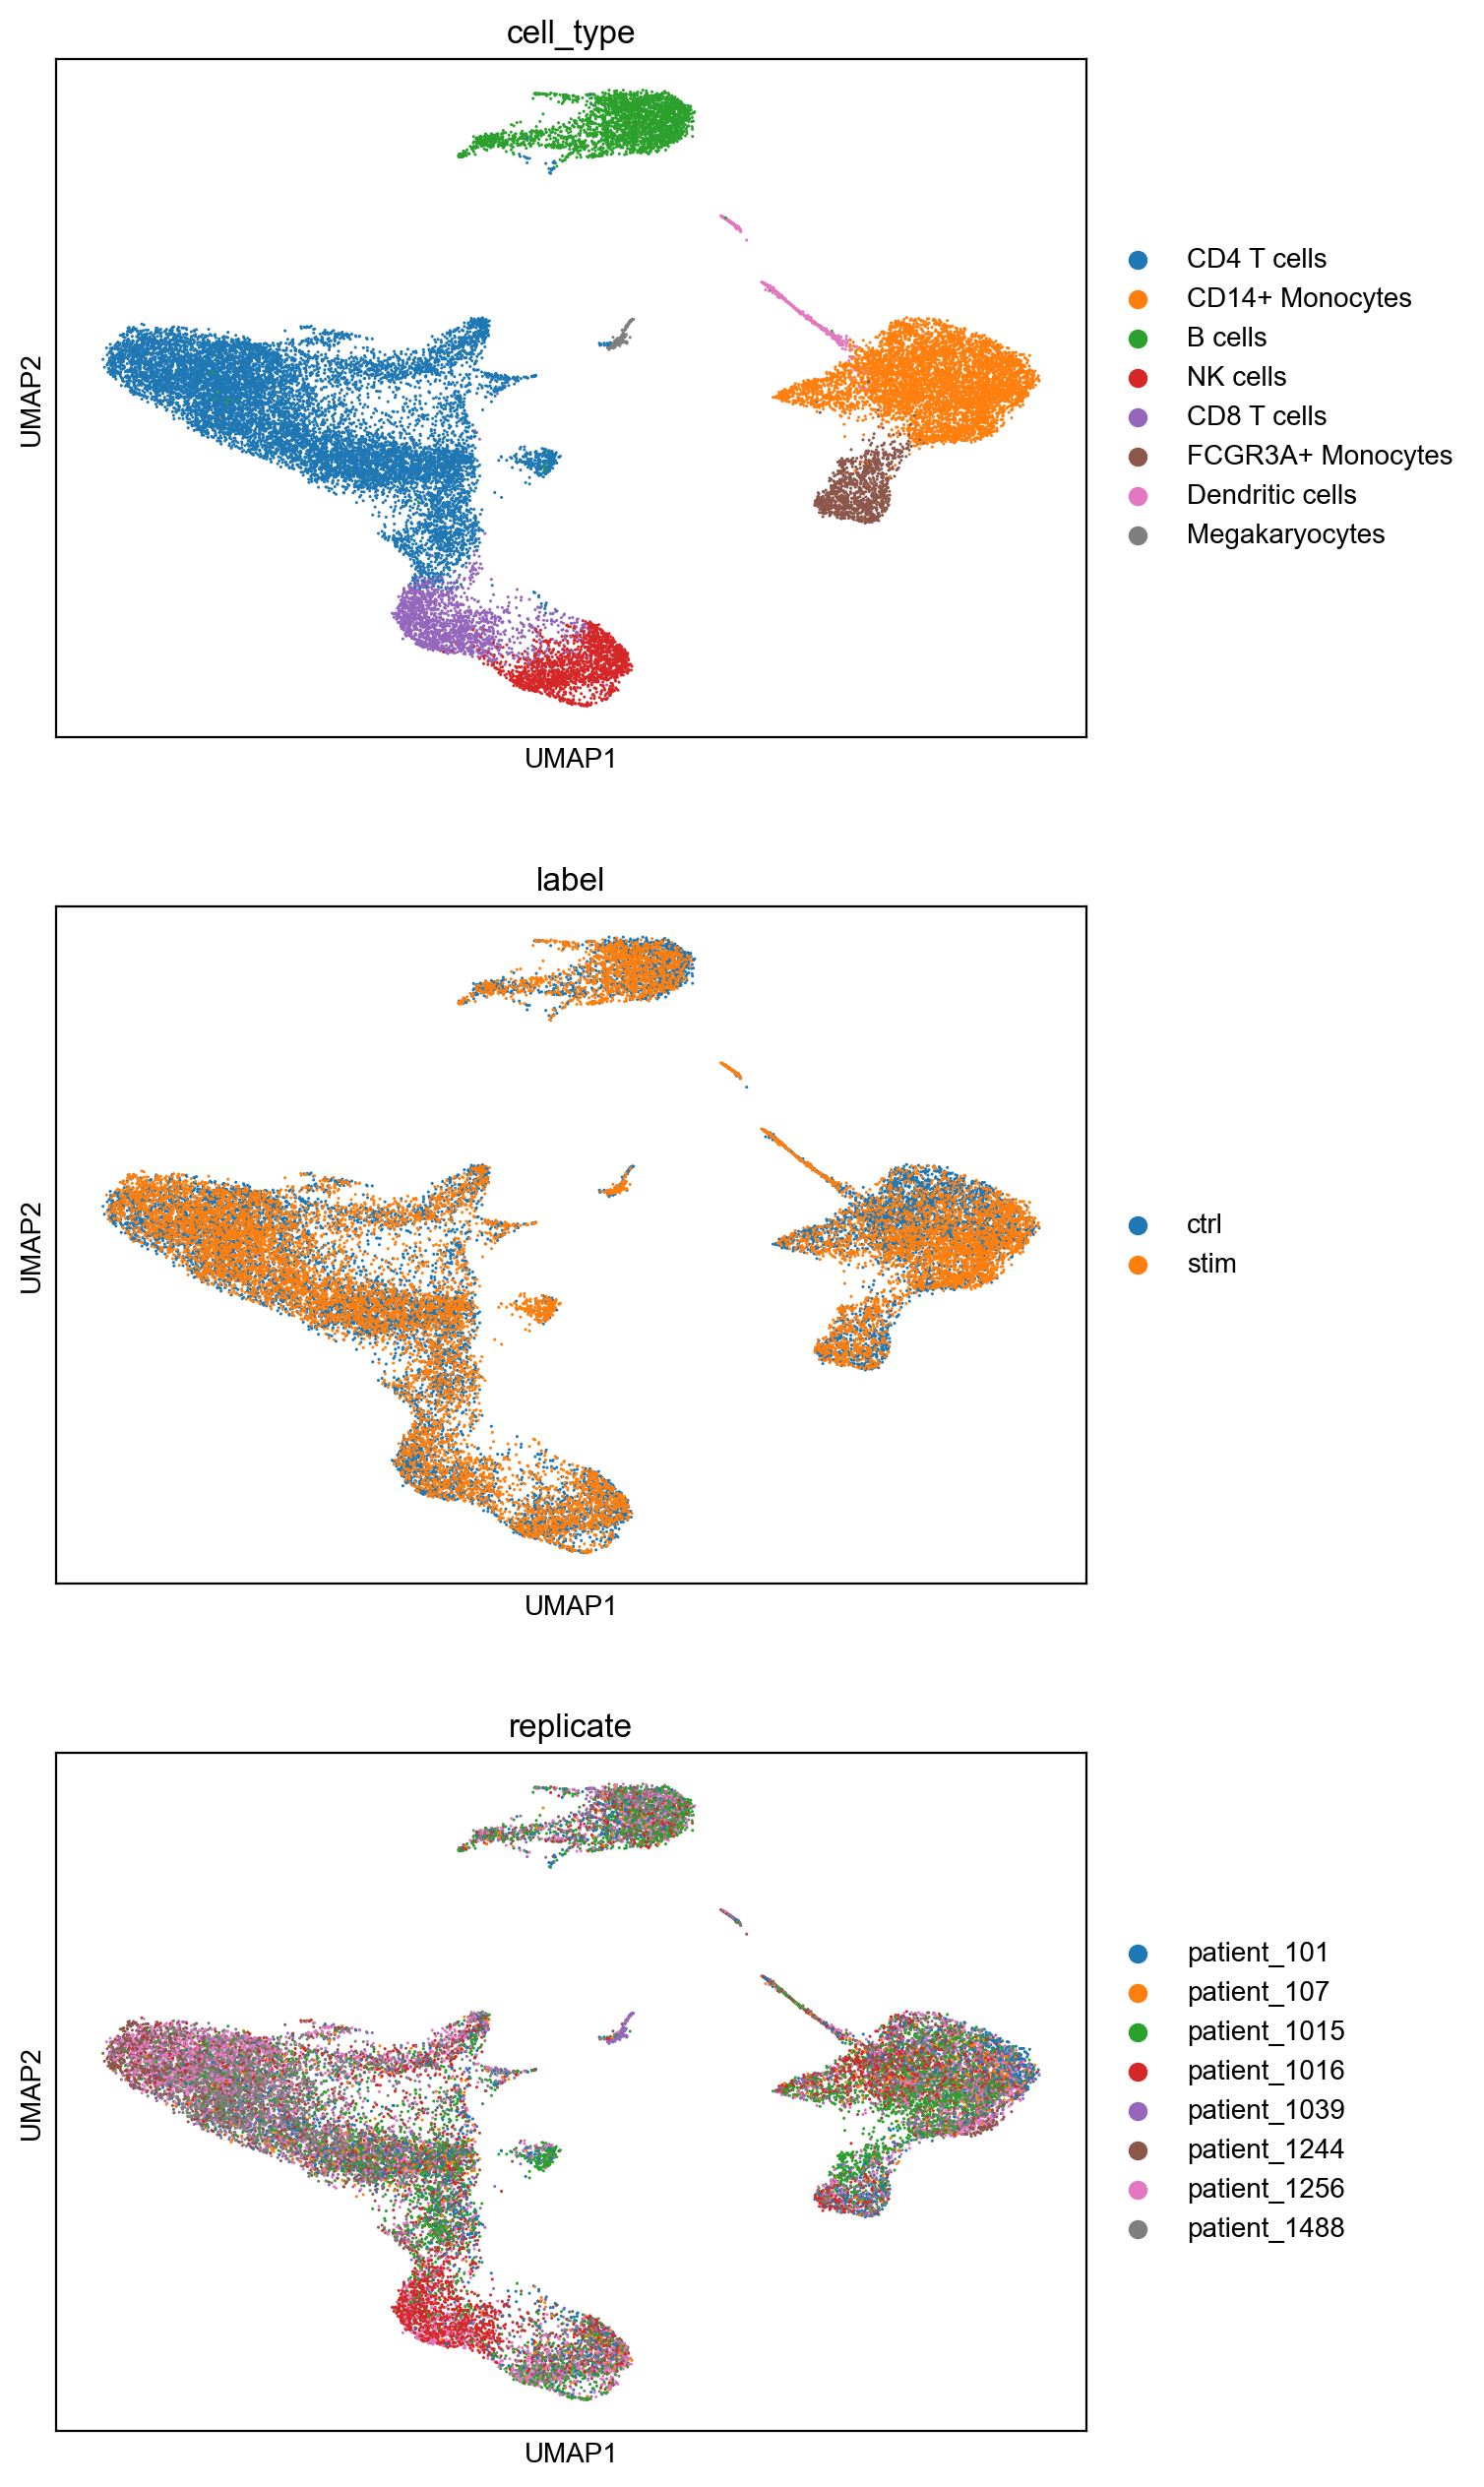

In [6]:
sc.pl.umap(adata, color=['cell_type', 'label', 'replicate'], ncols=1)

In [7]:
adata.layers['counts'] = adata.X.copy()
adata.obs['sample'] = adata.obs.apply(lambda x: x.replicate + '_' + x.label, axis=1).astype('category')

In [8]:
cell_subset = adata[adata.obs['cell_type'] == 'B cells']
cell_subset

View of AnnData object with n_obs × n_vars = 2651 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample'
    var: 'name'
    uns: 'cell_type_colors', 'label_colors', 'replicate_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [15]:
sample_key = 'sample'
condition_key = 'label'

In [16]:
pb = sctk.tl.create_pseudo_bulk(cell_subset, sample_key, condition_key)
pb

2024-01-02 16:02:51.161 | INFO     | sctk.tools.pseudobulk_DEG:create_pseudo_bulk:59 - Skipping group patient_107_ctrl with 44 cells, which is less than 50
2024-01-02 16:02:51.461 | INFO     | sctk.tools.pseudobulk_DEG:create_pseudo_bulk:59 - Skipping group patient_1039_ctrl with 26 cells, which is less than 50
2024-01-02 16:02:55.686 | INFO     | sctk.tools.pseudobulk_DEG:create_pseudo_bulk:59 - Skipping group patient_1039_stim with 41 cells, which is less than 50


AnnData object with n_obs × n_vars = 13 × 15706
    obs: 'condition', 'replicate', 'psbulk_n_cells', 'psbulk_counts'

In [11]:
pb.obs

,condition,replicate,psbulk_n_cells,psbulk_counts
patient_1256_ctrl_0,ctrl,0,218,260261.0
patient_1488_ctrl_0,ctrl,0,220,290330.0
patient_1015_ctrl_0,ctrl,0,459,556570.0
patient_1244_ctrl_0,ctrl,0,118,161291.0
patient_1016_ctrl_0,ctrl,0,125,152335.0
patient_101_ctrl_0,ctrl,0,106,124446.0
patient_1488_stim_0,stim,0,289,399790.0
patient_1016_stim_0,stim,0,123,150619.0
patient_1256_stim_0,stim,0,219,277533.0
patient_1015_stim_0,stim,0,366,481886.0


In [17]:
pb.X.A

array([[ 0.,  1.,  0., ...,  2.,  0., 18.],
       [ 0.,  0.,  0., ...,  4.,  0., 12.],
       [ 0.,  0.,  0., ...,  3.,  0., 47.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0., 12.],
       [ 0.,  0.,  0., ...,  0.,  0.,  8.],
       [ 0.,  0.,  0., ...,  0.,  0., 11.]], dtype=float32)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.52 seconds.

Fitting dispersion trend curve...
... done in 0.61 seconds.

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pydeseq2/utils.py:667: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pydeseq2/utils.py:708: RuntimeWarning: invalid value encountered in log
  x0=np.log(alpha_hat),
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pydeseq2/utils.py:667: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pydeseq2/utils.py:708: RuntimeWarning: invalid value encountered in log
  x0=np.log(alpha_hat),

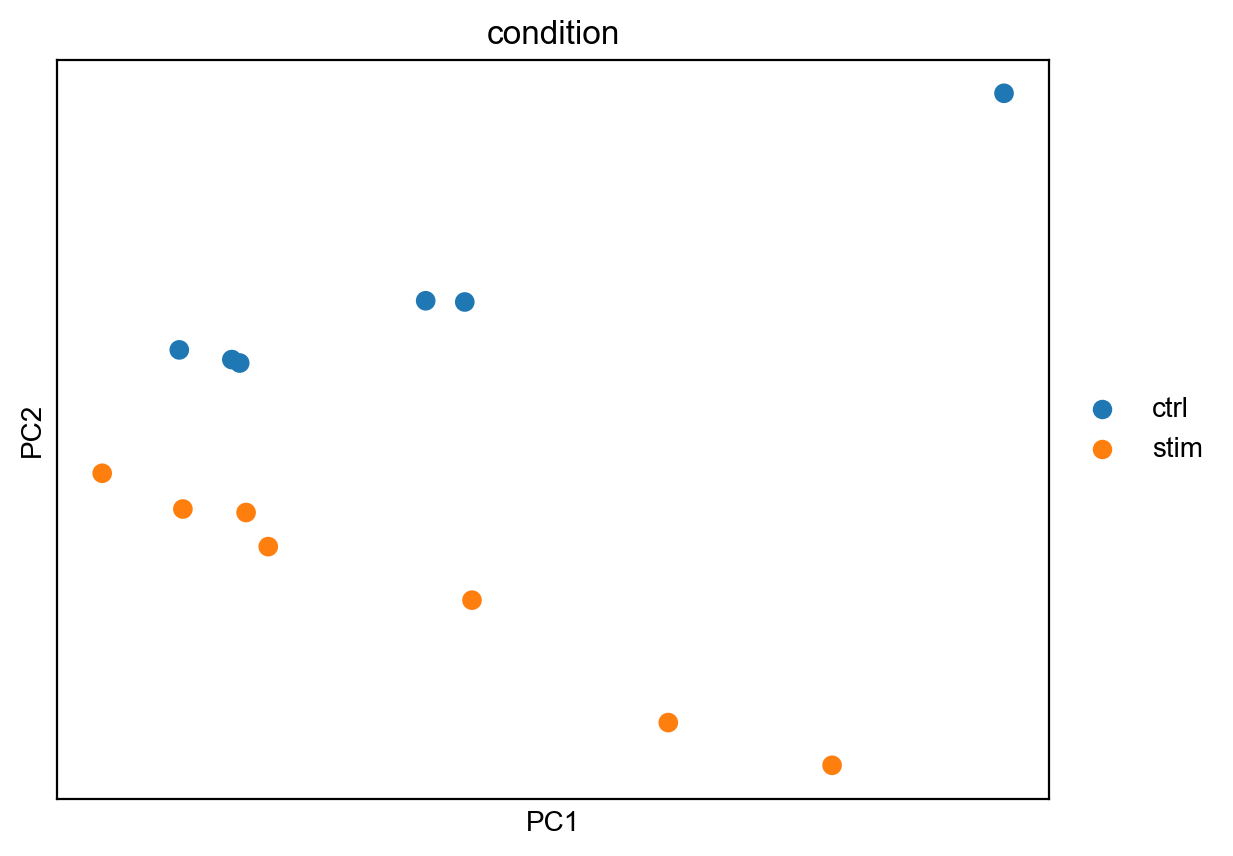

Running Wald tests...
... done in 7.93 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition stim vs ctrl
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
index                                                                    
RP11-206L10.2   0.058024       -0.257060  1.606091 -0.160053  0.872839   
RP11-206L10.9   0.120931       -0.324235  3.328519 -0.097411  0.922400   
FAM87B          0.053515       -0.255734  1.597477 -0.160086  0.872813   
LINC00115       0.506821        0.424026  1.369271  0.309673  0.756810   
FAM41C          0.094770        0.130593  1.961698  0.066571  0.946923   
...                  ...             ...       ...       ...       ...   
C21orf58        0.098359       -0.323209  3.200781 -0.100978  0.919568   
PCNT            0.370941       -0.239776  1.175546 -0.203970  0.838377   
DIP2A           0.950487       -0.372323  0.800388 -0.465177  0.641804   
S100B           0.120931       -0.324235  3.328519 -0.097411  0.922400   
PRMT2          15.745885        0.085199  0.257931 

... done in 4.58 seconds.



In [18]:
condition_key = 'condition'
treatment_key = 'stim'
control_key = 'ctrl'
de, dds = sctk.tl.run_deseq2(
    pb, condition_key=condition_key, treatment_key=treatment_key, control_key=control_key,
    plot_pca=True)

In [19]:
de

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
index,,,,,,
ISG15,946.526972,5.523789,0.193096,28.506752,9.661190e-179,7.089381e-175
IFIT3,341.725012,6.787585,0.245215,27.364257,7.307538e-165,2.681136e-161
LY6E,224.022194,4.205346,0.168285,24.959573,1.680957e-137,4.111621e-134
ISG20,1002.090428,3.273406,0.138821,23.627934,1.990391e-123,3.651372e-120
IFIT1,216.089120,6.492844,0.274611,23.494443,4.648752e-122,6.822509e-119
...,...,...,...,...,...,...
ZFP36L1,81.532872,-1.008303,0.134583,-7.695252,1.412157e-14,8.856757e-13
ARHGDIB,135.237368,-0.990011,0.127620,-7.928358,2.220620e-15,1.522889e-13
LINC00926,18.433484,-3.066105,0.329872,-9.474985,2.667991e-21,2.447215e-19


<Axes: xlabel='$\\mathrm{log_{2}}$(fold change)', ylabel='-$\\mathrm{log_{10}}$(p-value)'>

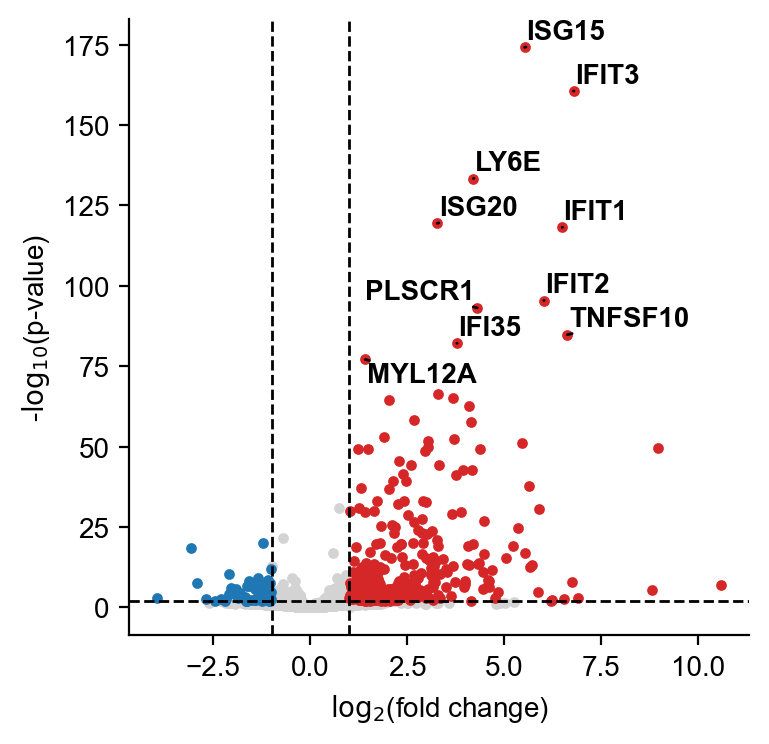

In [22]:
sctk.pl.plot_volcano(de, log2fc_key='log2FoldChange', pvalue_key='padj', n_top=10)

In [24]:
gene_list = list(de.sort_values('stat', ascending = False).index[:10])

In [25]:
pd.DataFrame(dds[:, gene_list].X, columns = gene_list, index = pb.obs_names)

,ISG15,IFIT3,LY6E,ISG20,IFIT1,IFIT2,PLSCR1,TNFSF10,IFI35,MYL12A
patient_1256_ctrl_0,60,11,33,244,8,11,22,3,12,208
patient_1488_ctrl_0,36,3,20,255,2,4,10,3,13,203
patient_1015_ctrl_0,143,23,71,561,16,16,49,7,30,466
patient_1244_ctrl_0,22,1,11,98,0,0,5,3,3,119
patient_1016_ctrl_0,33,6,24,168,8,2,10,3,12,110
patient_101_ctrl_0,14,0,9,83,0,4,8,2,9,79
patient_1488_stim_0,3327,1106,733,3299,762,607,446,468,286,734
patient_1016_stim_0,1155,436,322,1310,284,246,204,194,89,282
patient_1256_stim_0,2408,818,526,2254,559,374,327,350,188,537
patient_1015_stim_0,4455,1380,833,3838,980,526,629,709,344,922


In [33]:
from scipy.stats import zscore

In [26]:
dds.layers['normed_counts']

array([[ 0.75430778,  0.        ,  0.        , ...,  1.50861556,
         0.        , 13.57754008],
       [ 0.        ,  0.        ,  0.69569968, ...,  2.78279872,
         0.        ,  8.34839616],
       [ 0.        ,  0.        ,  0.        , ...,  1.07794915,
         0.        , 16.88786997],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 14.99048496],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 12.76672808],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 26.87321935]])

In [27]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])

In [38]:
dds.layers['zscore'] = zscore(dds.layers['normed_counts'], axis = 0)

In [28]:
res = de

In [29]:
sigs = res[(res.padj < 0.01) & (abs(res.log2FoldChange) > 1)]

In [30]:
dds_sigs = dds[:, sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 13 × 348
    obs: 'condition', 'replicate', 'psbulk_n_cells', 'psbulk_counts'
    var: 'n_cells'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var', 'pca', 'condition_colors'
    obsm: 'design_matrix', 'size_factors', 'replaceable', 'X_pca'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'PCs'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks', 'log1p'

In [41]:
grapher = pd.DataFrame(
    dds_sigs.layers['log1p'].T,
    index=dds_sigs.var_names, columns=dds_sigs.obs_names)

Text(630.9027777777777, 0.5, 'Genes')

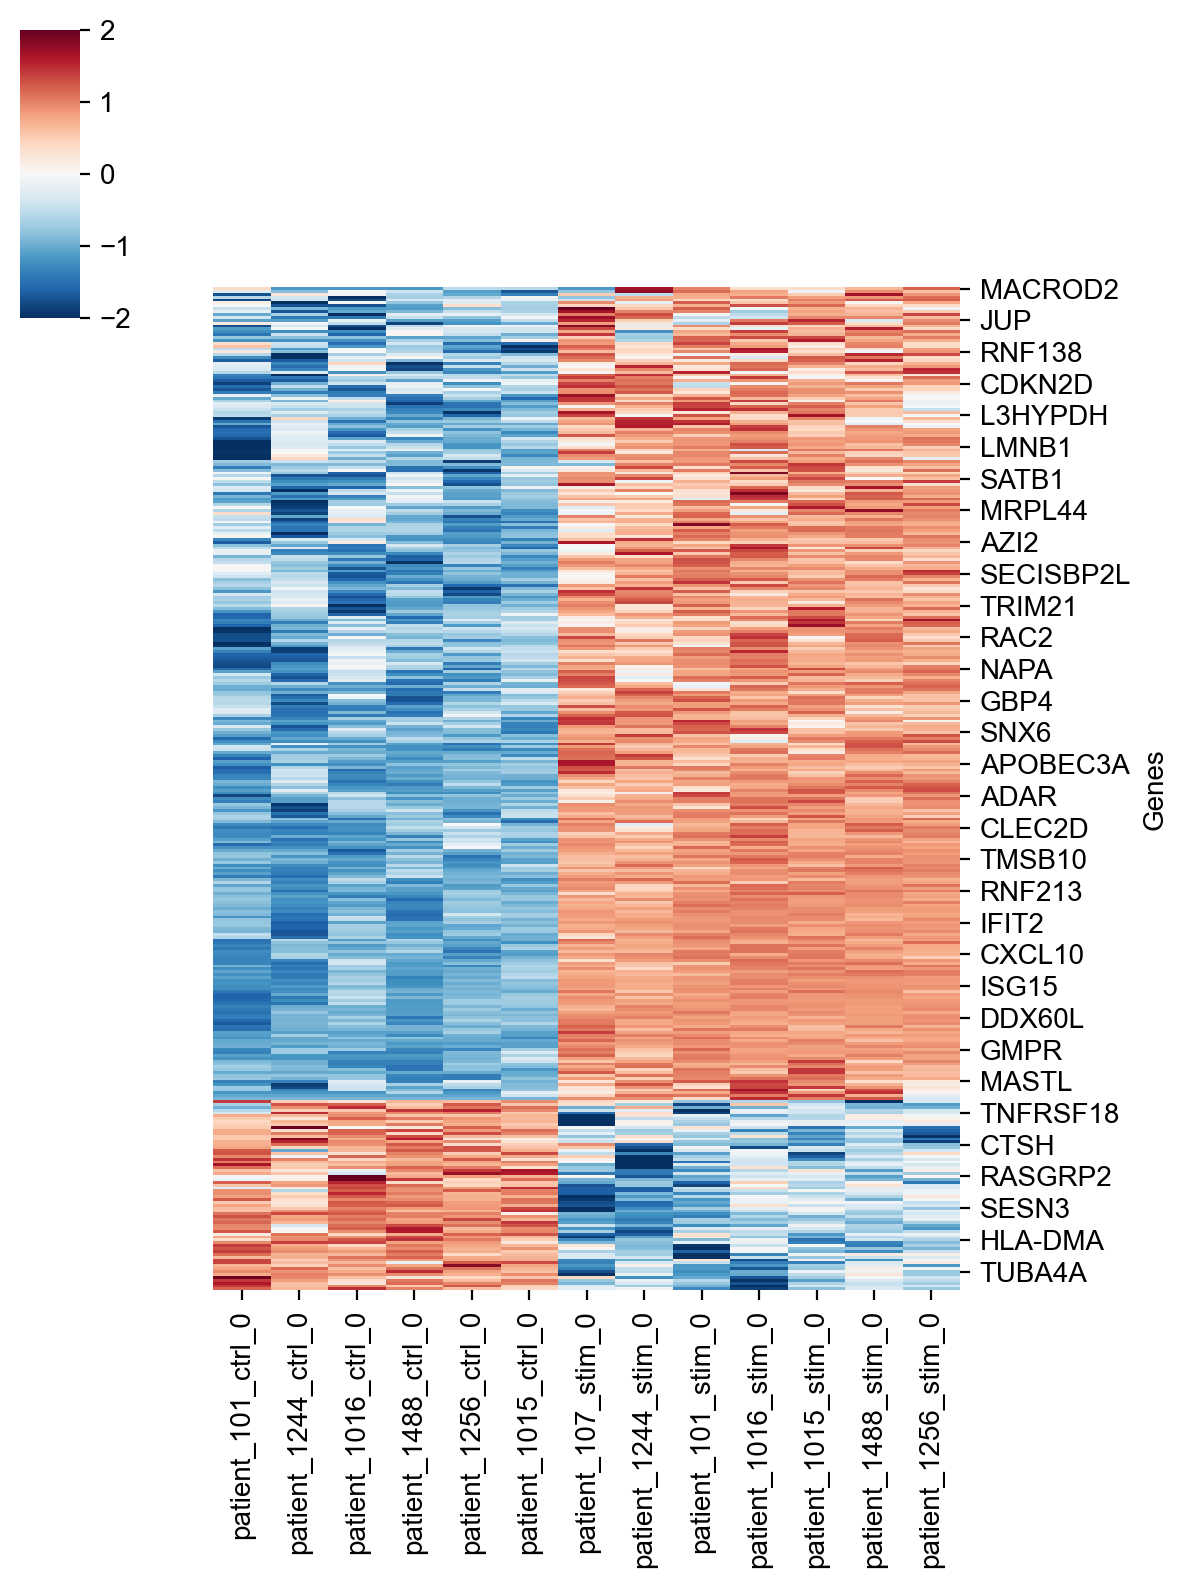

In [53]:
g = sns.clustermap(grapher, z_score=0, cmap = 'RdBu_r', vmax=2, vmin=-2, figsize=(6, 8))
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

ax = g.ax_heatmap
ax.set_ylabel('Genes')